In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

def load_data(folder):
    data = []
    labels = []
    for label, subfolder in enumerate(['control', 'condition']):
        path = os.path.join(folder, subfolder)
        for file in os.listdir(path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(path, file))
                data.append(df[['timestamp', 'activity']].values)
                labels.append(label)
    return data, labels

data, labels = load_data('data')

In [6]:
def preprocess_data(data):
    processed_data = []
    for sequence in data:
        df = pd.DataFrame(sequence, columns=['timestamp', 'activity'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        processed_data.append(df[['hour', 'activity']].values)
    return processed_data

processed_data = preprocess_data(data)

scaler = StandardScaler()
for i in range(len(processed_data)):
    processed_data[i] = scaler.fit_transform(processed_data[i])

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

In [8]:
max_len = max(len(seq) for seq in processed_data)
X = pad_sequences(processed_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
y = np.array(labels)


In [9]:
# Reshape X for SMOTE
n_samples, time_steps, n_features = X.shape
X_reshaped = X.reshape((n_samples, time_steps * n_features))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

# Reshape X back to original form
X_resampled = X_resampled.reshape((X_resampled.shape[0], time_steps, n_features))

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [14]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(input_shape)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/20


c:\Users\vinse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 147s 69s/step - accuracy: 0.4125 - loss: 1.4986 - val_accuracy: 0.7273 - val_loss: 2.5549
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 146s 68s/step - accuracy: 0.7333 - loss: 2.5421 - val_accuracy: 0.7273 - val_loss: 2.5623
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 152s 69s/step - accuracy: 0.7667 - loss: 1.6277 - val_accuracy: 1.0000 - val_loss: 0.1100
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 154s 69s/step - accuracy: 0.7771 - loss: 1.4170 - val_accuracy: 0.7273 - val_loss: 0.4915
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 154s 69s/step - accuracy: 0.7833 - loss: 1.0089 - val_accuracy: 0.9091 - val_loss: 0.2554
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 160s 72s/step - accuracy: 0.9729 - loss: 0.1022 - val_accuracy: 0.7273 - val_loss: 1.2461
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 154s 70s/step - accuracy: 0.9292 - loss: 0.2933 - val_accuracy: 0.6364 - val_loss: 2.0733
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 159s 69s/step - accuracy: 0.8750 - loss: 0.2953 - val_accuracy: 0.9091 - val_loss: 0.9865
Epo

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
# Model Evaluation Section
# Assuming you have the true labels and predictions ready
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Insert the new code here
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='binary')  # Use 'micro', 'macro', 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision: 0.8571
Recall: 0.8571
F1 Score: 0.8571


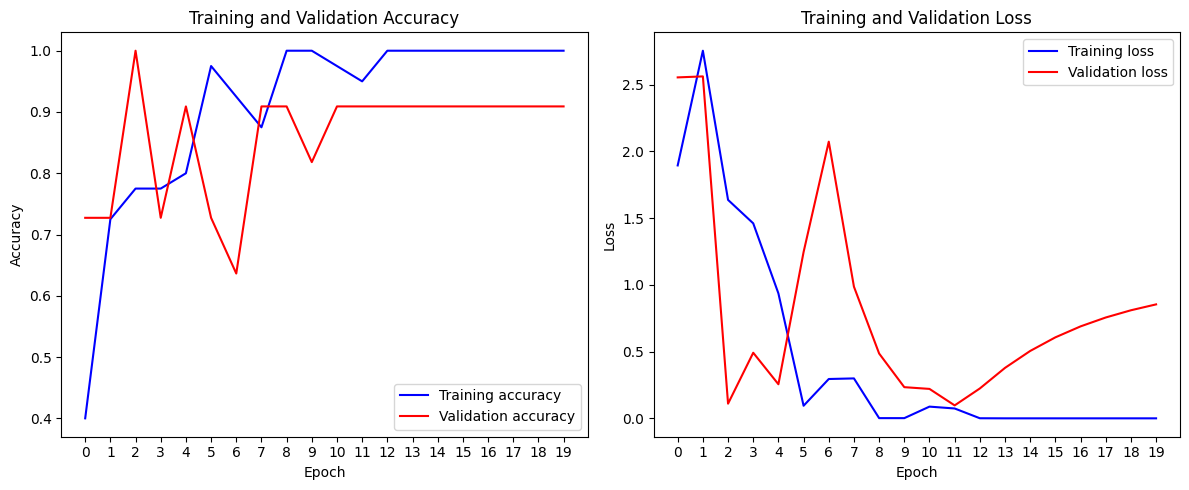

In [17]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, len(epochs), 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(epochs), 1))
plt.legend()

plt.tight_layout()
plt.show()